In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import logging
from typing import Optional, Dict, Tuple

# --- Configuration ---
LOG_FILE = "aavegotchi_analysis.log"
PLOTS_OUTPUT_DIR = "aavegotchi_plots"

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Ensure output directory for plots exists
os.makedirs(PLOTS_OUTPUT_DIR, exist_ok=True)

In [19]:
def load_aavegotchi_data(base_dir: str = "") -> Dict[str, pd.DataFrame]:
    datasets = {}
    file_names = {
        "sales": "Aavegotchi_sales.csv",
        "ghst_price": "GHST.csv",
        "wearables": "Wearable_sales.csv"
    }

    logger.info(f"Attempting to load datasets from '{base_dir if base_dir else 'current directory'}'")

    for key, file_name in file_names.items():
        file_path = os.path.join(base_dir, file_name)
        if not os.path.exists(file_path):
            logger.error(f"File '{file_path}' not found. Please ensure all CSVs are in the specified folder or current directory.")
            return {}

        try:
            df = pd.read_csv(file_path, low_memory=False)
            datasets[key] = df
            logger.info(f"Dataset '{file_name}' loaded successfully! Rows: {len(df)}")

        except Exception as e:
            logger.error(f"Error loading dataset {file_name}: {e}")
            return {}

    logger.info("All Aavegotchi datasets loaded.")
    return datasets

In [20]:
def preprocess_aavegotchi_data(datasets: Dict[str, pd.DataFrame]) -> Optional[pd.DataFrame]:
    if not datasets:
        logger.error("No datasets provided for preprocessing.")
        return None

    sales_df = datasets["sales"].copy()
    ghst_df = datasets["ghst_price"].copy()

    logger.info("Starting data preprocessing and feature engineering.")

    sales_df['Date'] = pd.to_datetime(sales_df['Date'], errors='coerce')
    ghst_df['Date'] = pd.to_datetime(ghst_df['Date'], errors='coerce')

    sales_df.dropna(subset=['Date'], inplace=True)
    ghst_df.dropna(subset=['Date'], inplace=True)

    ghst_df.rename(columns={'Price': 'GHST_Daily_Close_Price_USD'}, inplace=True)

    df_processed = pd.merge(sales_df, ghst_df[['Date', 'GHST_Daily_Close_Price_USD']], on='Date', how='left')

    missing_ghst_price = df_processed['GHST_Daily_Close_Price_USD'].isna().sum()
    if missing_ghst_price > 0:
        logger.warning(f"Found {missing_ghst_price} missing GHST_Daily_Close_Price_USD after merge. Dropping these rows.")
        df_processed.dropna(subset=['GHST_Daily_Close_Price_USD'], inplace=True)

    df_processed['log_USD_price'] = np.log1p(df_processed['$USD_price'])

    df_processed['sale_year'] = df_processed['Date'].dt.year
    df_processed['sale_month'] = df_processed['Date'].dt.month
    df_processed['sale_day'] = df_processed['Date'].dt.day
    df_processed['sale_day_of_week'] = df_processed['Date'].dt.day_name()
    df_processed['sale_week_of_year'] = df_processed['Date'].dt.isocalendar().week.astype(int)

    df_processed['Wearables'] = df_processed['Wearables'].apply(lambda x: eval(x) if isinstance(x, str) else x)
    df_processed['num_wearables'] = df_processed['Wearables'].apply(lambda x: len([w for w in x if w != 0]))

    num_slots = 16
    for i in range(num_slots):
        df_processed[f'wearable_slot_{i}_present'] = df_processed['Wearables'].apply(lambda x: 1 if i < len(x) and x[i] != 0 else 0)

    df_processed['HAUNT'] = df_processed['HAUNT'].astype('category')
    df_processed['sale_day_of_week'] = df_processed['sale_day_of_week'].astype('category')

    logger.info("Data preprocessing and feature engineering completed.")
    return df_processed

In [21]:
#  4: Machine Learning Model Training and Initial Evaluation

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

def train_and_evaluate_model(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    if df is None or df.empty:
        logger.error("Processed DataFrame is empty. Cannot proceed with modeling.")
        return np.array([]), np.array([])

    logger.info("Starting machine learning modeling.")

    y = df['log_USD_price']

    features = [col for col in df.columns if col not in [
        '$GHST_price', 'ID', 'Wearables', 'Seller', 'Buyer',
        'Date', '$USD_price', 'log_USD_price',
        'GHST_Daily_Close_Price_USD'
    ]]
    X = df[features]

    categorical_features = X.select_dtypes(include=['category']).columns.tolist()

    for col in X.select_dtypes(include=['object']).columns:
        if col not in ['Seller', 'Buyer']:
            X[col] = X[col].astype('category')
            categorical_features.append(col)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lgb_model = lgb.LGBMRegressor(objective='regression_l1',
                                  metric='rmse',
                                  n_estimators=1000,
                                  learning_rate=0.05,
                                  num_leaves=31,
                                  max_depth=-1,
                                  min_child_samples=20,
                                  subsample=0.8,
                                  colsample_bytree=0.8,
                                  random_state=42,
                                  n_jobs=-1)

    logger.info("Training LightGBM model...")
    lgb_model.fit(X_train, y_train,
                  categorical_feature=categorical_features,
                  eval_set=[(X_test, y_test)],
                  eval_metric='rmse',
                  callbacks=[lgb.early_stopping(100, verbose=False)])

    logger.info("LightGBM model training complete.")

    y_pred_log = lgb_model.predict(X_test)
    y_pred_usd = np.expm1(y_pred_log)
    y_test_usd = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_usd, y_pred_usd))
    r2 = r2_score(y_test_usd, y_pred_usd)
    competition_score = np.exp(-rmse / 10)

    print("\n" + "="*50)
    print("Model Evaluation (on original USD scale):")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print(f"Competition Score (exp(-RMSE/10)): {competition_score:.4f}")
    print("="*50 + "\n")

    return y_test_usd, y_pred_usd

In [22]:
#  Cross-Validation and Feature Importance

from sklearn.model_selection import KFold

def run_cross_validation_and_feature_importance(df: pd.DataFrame) -> None:
    if df is None or df.empty:
        logger.error("Processed DataFrame is empty. Cannot proceed with Cross-Validation.")
        return

    logger.info("Starting K-Fold Cross-Validation and Feature Importance analysis.")

    y = df['log_USD_price']
    features = [col for col in df.columns if col not in [
        '$GHST_price', 'ID', 'Wearables', 'Seller', 'Buyer',
        'Date', '$USD_price', 'log_USD_price',
        'GHST_Daily_Close_Price_USD'
    ]]
    X = df[features]

    categorical_features = X.select_dtypes(include=['category']).columns.tolist()
    for col in X.select_dtypes(include=['object']).columns:
        if col not in ['Seller', 'Buyer']:
            X[col] = X[col].astype('category')
            categorical_features.append(col)

    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_rmse_scores_usd = []
    fold_r2_scores = []
    fold_competition_scores = []
    fold_feature_importances = pd.DataFrame(index=X.columns)

    logger.info(f"Running {n_splits}-Fold Cross-Validation...")

    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        logger.info(f"--- Fold {fold + 1}/{n_splits} ---")
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        lgb_model = lgb.LGBMRegressor(objective='regression_l1',
                                      metric='rmse',
                                      n_estimators=1000,
                                      learning_rate=0.05,
                                      num_leaves=31,
                                      max_depth=-1,
                                      min_child_samples=20,
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                      random_state=42,
                                      n_jobs=-1)

        lgb_model.fit(X_train, y_train,
                      categorical_feature=categorical_features,
                      eval_set=[(X_val, y_val)],
                      eval_metric='rmse',
                      callbacks=[lgb.early_stopping(100, verbose=False)])

        y_pred_log_val = lgb_model.predict(X_val)
        y_pred_usd_val = np.expm1(y_pred_log_val)
        y_val_usd = np.expm1(y_val)

        fold_rmse = np.sqrt(mean_squared_error(y_val_usd, y_pred_usd_val))
        fold_r2 = r2_score(y_val_usd, y_pred_usd_val)
        fold_competition_score = np.exp(-fold_rmse / 10)

        fold_rmse_scores_usd.append(fold_rmse)
        fold_r2_scores.append(fold_r2)
        fold_competition_scores.append(fold_competition_score)

        fold_feature_importances[f'Fold_{fold+1}'] = lgb_model.feature_importances_

        print(f"Fold {fold + 1} - RMSE: {fold_rmse:.4f}, R2: {fold_r2:.4f}, Competition Score: {fold_competition_score:.4f}")

    print("\n" + "="*50)
    print(f"Mean Cross-Validation Results ({n_splits} Folds):")
    print(f"Average RMSE (USD): {np.mean(fold_rmse_scores_usd):.4f} (+/- {np.std(fold_rmse_scores_usd):.4f})")
    print(f"Average R-squared (R2): {np.mean(fold_r2_scores):.4f} (+/- {np.std(fold_r2_scores):.4f})")
    print(f"Average Competition Score: {np.mean(fold_competition_scores):.4f} (+/- {np.std(fold_competition_scores):.4f})")
    print("="*50 + "\n")

    logger.info("Calculating and visualizing Feature Importance.")

    avg_feature_importances = fold_feature_importances.mean(axis=1).sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=avg_feature_importances.values, y=avg_feature_importances.index, palette='viridis')
    plt.title('Feature Importance (Average Across CV Folds)')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_OUTPUT_DIR, 'feature_importance.png'))
    plt.show()

    logger.info("Feature Importance plot saved.")
    logger.info("Cross-Validation and Feature Importance analysis completed.")

In [23]:
# Cell 6: Visualize Model Performance and Errors

def visualize_model_performance(y_true: np.ndarray, y_pred: np.ndarray, output_dir: str) -> None:
    if y_true.size == 0 or y_pred.size == 0:
        logger.error("True or predicted values are empty. Cannot visualize model performance.")
        return

    logger.info("Starting model performance visualization.")
    os.makedirs(output_dir, exist_ok=True)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title('True Prices vs. Predicted Prices (USD)')
    plt.xlabel('True Price (USD)')
    plt.ylabel('Predicted Price (USD)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'true_vs_predicted_prices.png'))
    plt.show()
    logger.info("True vs. Predicted Prices plot saved.")

    errors = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=50, kde=True, color='skyblue')
    plt.axvline(0, color='red', linestyle='--', label='Zero Error')
    plt.title('Distribution of Prediction Errors (True - Predicted)')
    plt.xlabel('Prediction Error (USD)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'prediction_errors_distribution.png'))
    plt.show()
    logger.info("Prediction Errors Distribution plot saved.")

    logger.info("Model performance visualization complete.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1214
[LightGBM] [Info] Number of data points in the train set: 10876, number of used features: 23
[LightGBM] [Info] Start training from score 0.998683

Model Evaluation (on original USD scale):
Root Mean Squared Error (RMSE): 0.0410
R-squared (R2): 0.9905
Competition Score (exp(-RMSE/10)): 0.9959

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1214
[LightGBM] [Info] Number of data points in the train set: 10876, number of used features: 23
[LightGBM] [Info] Start training from score 0.998683
Fold 1 - RMSE: 0.0410, R2: 0.9905, Competition Score: 0.9959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001457 seconds.
You

/tmp/ipython-input-22-3736144238.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_feature_importances.values, y=avg_feature_importances.index, palette='viridis')


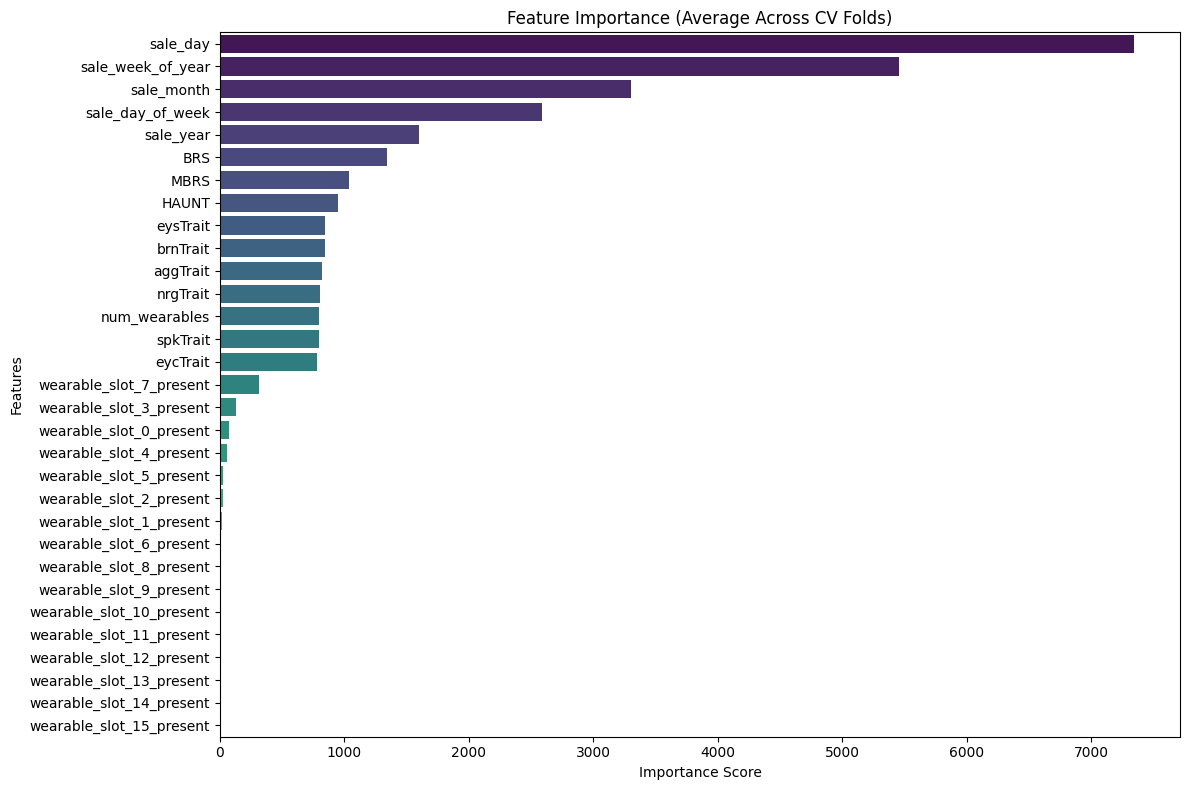

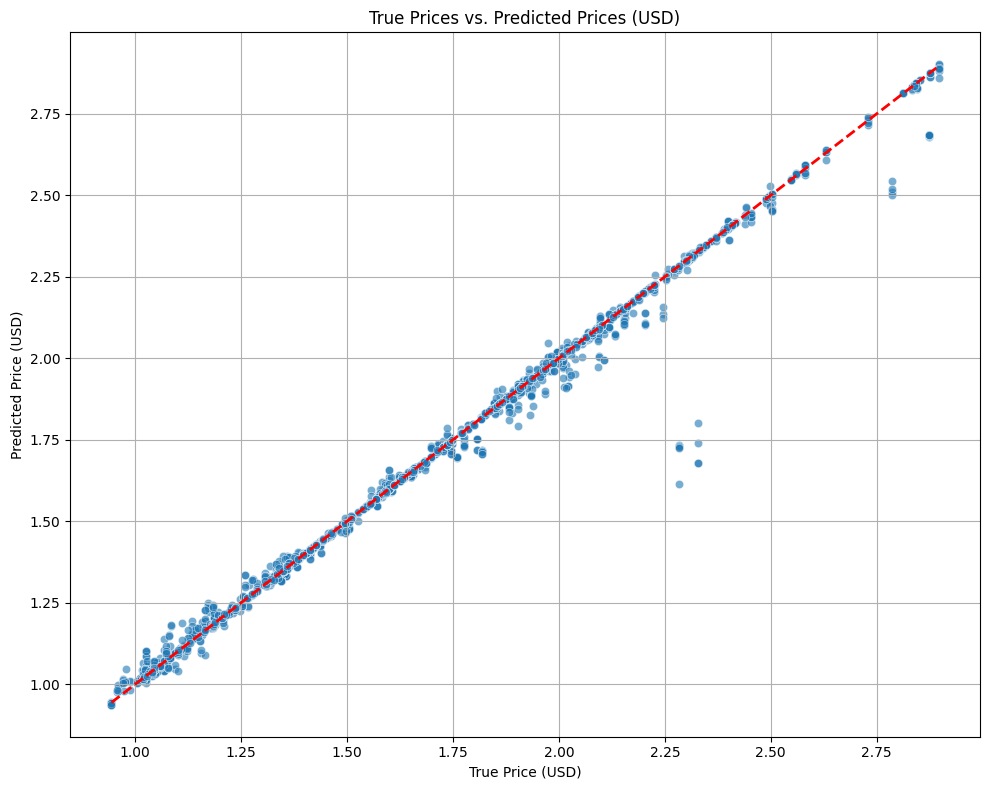

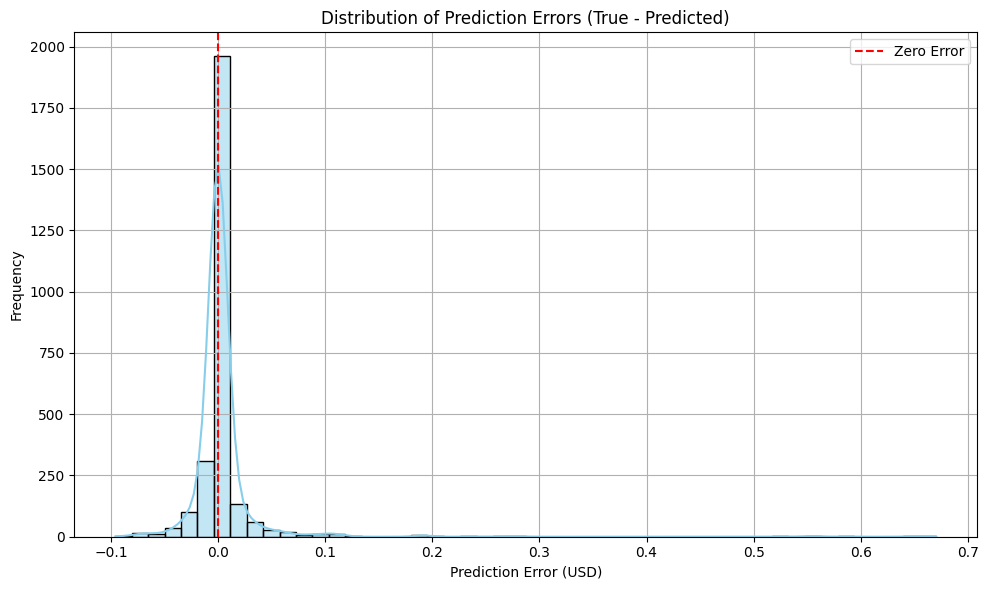

In [24]:
# Cell 7: Main Execution Flow

def main():
    logger.info("Starting Aavegotchi NFT Price Prediction Project.")

    # Load Data
    aavegotchi_data = load_aavegotchi_data("")
    if not aavegotchi_data:
        logger.error("Data loading failed. Exiting.")
        return

    # Preprocess Data and Engineer Features
    processed_df = preprocess_aavegotchi_data(aavegotchi_data)
    if processed_df is None:
        logger.error("Data preprocessing failed. Exiting.")
        return

    # Train and Evaluate Model (Initial Split)
    y_test_usd, y_pred_usd = train_and_evaluate_model(processed_df)

    # Run Cross-Validation and Feature Importance
    run_cross_validation_and_feature_importance(processed_df)

    # Visualize Model Performance
    visualize_model_performance(y_test_usd, y_pred_usd, PLOTS_OUTPUT_DIR)

    logger.info("Aavegotchi NFT Price Prediction Project completed successfully!")

if __name__ == "__main__":
    main()
